<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.utils import shuffle

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0-rc1


In [2]:
# get the data
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip
!unzip -n ml-20m.zip
df = pd.read_csv("ml-20m/ratings.csv")
df.head()

--2019-12-17 12:11:55--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  26.0MB/s    in 8.0s    

2019-12-17 12:12:04 (23.8 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [0]:
# create new index for our model instead of using ids in the dataset
# can't really trust ids in the dataset

df.userId = pd.Categorical(df.userId)
df["new_user_id"] = df.userId.cat.codes
df.movieId = pd.Categorical(df.movieId)
df["new_movie_id"] = df.movieId.cat.codes

In [0]:
# get the values from data frame objects

user_ids = df["new_user_id"].values
movie_ids = df["new_movie_id"].values
ratings = df["rating"].values

In [5]:
# build a neural network

N = len(set(user_ids))
M = len(set(movie_ids))
K = 10 # embedding dimension

# user input
u = Input(shape=(1,))

# movie input
m = Input(shape=(1,))

# user embedding
u_emb = Embedding(N, K)(u)

# movie embedding
m_emb = Embedding(M, K)(m)

# flatten both embeddings
u_emb = Flatten()(u_emb)
m_emb = Flatten()(m_emb)

# concat two tensors
x = Concatenate()([u_emb, m_emb])

# fully connect to neurons
x = Dense(1024, activation="relu")(x)
x = Dense(1)(x)

model = Model(inputs=[u, m], outputs=x)
model.compile(loss="mse", optimizer=SGD(lr=0.08, momentum=0.9))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        1384930     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        267440      input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
# split the data
user_ids, movie_ids, ratings = shuffle(user_ids,  movie_ids, ratings)
Ntrain = int(0.8 * len(ratings))
train_user = user_ids[:Ntrain]
train_movie = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_user = user_ids[Ntrain:]
test_movie = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

# center the ratings
avg_ratings = train_ratings.mean()
train_ratings = train_ratings - avg_ratings
test_ratings = test_ratings - avg_ratings

In [7]:
# train the model
param_kwargs = {
    "x": [train_user, train_movie],
    "y": train_ratings,
    "epochs": 25,
    "batch_size": 1024,
    "validation_data": ([test_user, test_movie], test_ratings)
}
r = model.fit(**param_kwargs)

Train on 16000210 samples, validate on 4000053 samples
Epoch 1/25
16000210/16000210 [==============================] - 72s 4us/sample - loss: 0.7784 - val_loss: 0.7302
Epoch 2/25
16000210/16000210 [==============================] - 68s 4us/sample - loss: 0.7024 - val_loss: 0.6984
Epoch 3/25
16000210/16000210 [==============================] - 69s 4us/sample - loss: 0.6789 - val_loss: 0.6909
Epoch 4/25
16000210/16000210 [==============================] - 69s 4us/sample - loss: 0.6628 - val_loss: 0.6750
Epoch 5/25
16000210/16000210 [==============================] - 69s 4us/sample - loss: 0.6519 - val_loss: 0.6689
Epoch 6/25
16000210/16000210 [==============================] - 69s 4us/sample - loss: 0.6396 - val_loss: 0.6639
Epoch 7/25
16000210/16000210 [==============================] - 69s 4us/sample - loss: 0.6245 - val_loss: 0.6506
Epoch 8/25
16000210/16000210 [==============================] - 69s 4us/sample - loss: 0.6101 - val_loss: 0.6436
Epoch 9/25
16000210/16000210 [===========

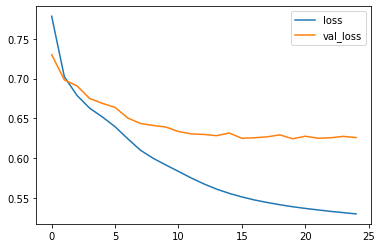

In [8]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()